# 03 - Retention and cohorts (anime_simulated)

In this notebook we:

- Load the synthetic viewing logs generated by the pipeline
- Compute retention curves by episode number
- Look at binge depth per user and per anime
- Build simple time-based cohorts and survival-style retention

In [1]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parents[1]  # sim2real user engagement
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

In [3]:
from anime_simulated.src.config import PROCESSED_DIR, VIEWING_LOGS_FILE

In [4]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


In [5]:
logs_path = PROCESSED_DIR / VIEWING_LOGS_FILE
logs_path

PosixPath('/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/anime_simulated/data/processed/viewing_logs.parquet')

In [6]:
logs_df = pd.read_parquet(logs_path)
logs_df.head()

,user_id,engagement_level,anime_row_id,anime_title,episode_number,watch_start_time,watch_time_sec,completed_fraction,label_next_episode,p_continue
0,1,0.424548,9258,Fushigiboshi no☆Futagohime,1,2024-01-11 00:00:00.000000,1200,1.000000,1,0.752300
1,1,0.424548,9258,Fushigiboshi no☆Futagohime,2,2024-01-12 05:33:18.614273,873,0.728261,1,0.641141
2,1,0.424548,9258,Fushigiboshi no☆Futagohime,3,2024-01-12 07:19:33.763768,824,0.686921,0,0.648255
3,1,0.424548,19600,Magnerobo Ga-Keen,1,2024-01-01 00:00:00.000000,971,0.809331,1,0.779796
4,1,0.424548,19600,Magnerobo Ga-Keen,2,2024-01-02 19:40:27.893000,894,0.745706,1,0.667751


## Basic overview

Quick checks:

- Shape of the log table
- Data types
- Date range of `watch_start_time`
- Number of users and anime

In [7]:
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50703 entries, 0 to 50702
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             50703 non-null  int64         
 1   engagement_level    50703 non-null  float64       
 2   anime_row_id        50703 non-null  int64         
 3   anime_title         50703 non-null  object        
 4   episode_number      50703 non-null  int64         
 5   watch_start_time    50703 non-null  datetime64[ns]
 6   watch_time_sec      50703 non-null  int64         
 7   completed_fraction  50703 non-null  float64       
 8   label_next_episode  50703 non-null  int64         
 9   p_continue          50703 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 3.9+ MB


In [10]:
print("Rows:", len(logs_df))
print("Unique users:", logs_df["user_id"].nunique())
print("Unique anime:", logs_df["anime_row_id"].nunique())
print("Episode range:", logs_df["episode_number"].min(), "to", logs_df["episode_number"].max())
print("Watch start time range:", logs_df["watch_start_time"].min(), "to", logs_df["watch_start_time"].max())

Rows: 50703
Unique users: 5000
Unique anime: 7129
Episode range: 1 to 16
Watch start time range: 2024-01-01 00:00:00 to 2024-02-13 11:38:52.970926


## Retention by episode number

We use the label created by the simulator:

- `label_next_episode = 1` if the user watched the next episode of the same anime
- `0` otherwise

For each `episode_number`, we compute:

- Mean of `label_next_episode` as an estimate of continuation probability.

In [11]:
retention_by_episode = (
    logs_df
    .groupby("episode_number")["label_next_episode"]
    .mean()
    .reset_index()
    .sort_values("episode_number")
)
retention_by_episode.head(15)

,episode_number,label_next_episode
0,1,0.792241
1,2,0.738691
2,3,0.692210
3,4,0.656432
4,5,0.614159
5,6,0.560313
6,7,0.587068
7,8,0.521902
8,9,0.502415
9,10,0.466346


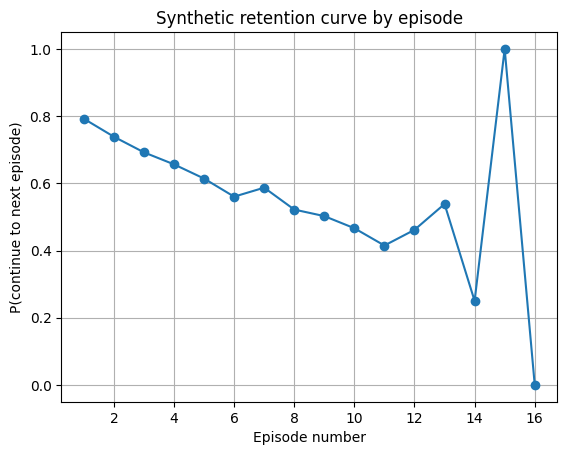

In [12]:
plt.figure()
plt.plot(
    retention_by_episode["episode_number"],
    retention_by_episode["label_next_episode"],
    marker="o",
)
plt.xlabel("Episode number")
plt.ylabel("P(continue to next episode)")
plt.title("Synthetic retention curve by episode")
plt.grid(True)
plt.show()


## Binge depth per user and per anime

- How many total episodes each user watches across all anime
- How deep users go into a given anime (max episode reached per user-anime pair)

In [13]:
user_total_episodes = (
    logs_df.groupby("user_id")["episode_number"]
    .count()
    .rename("episodes_watched")
    .reset_index()
)
user_total_episodes["episodes_watched"].describe()

count    5000.000000
mean       10.140600
std         6.712395
min         1.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        41.000000
Name: episodes_watched, dtype: float64

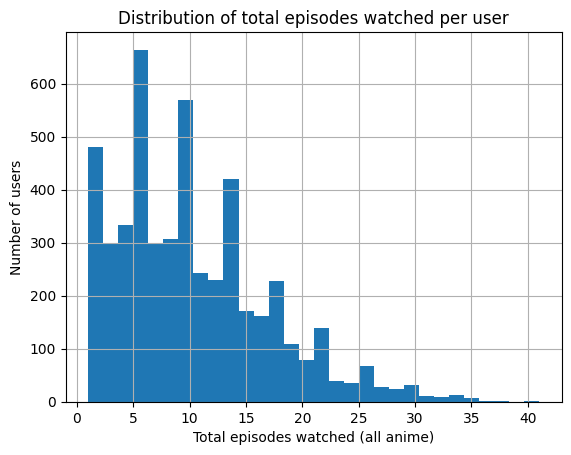

In [14]:
plt.figure()
user_total_episodes["episodes_watched"].hist(bins=30)
plt.xlabel("Total episodes watched (all anime)")
plt.ylabel("Number of users")
plt.title("Distribution of total episodes watched per user")
plt.show()

In [15]:
per_user_anime_depth = (
    logs_df.groupby(["user_id", "anime_row_id"])["episode_number"]
    .max()
    .rename("max_episode_watched")
    .reset_index()
)
per_user_anime_depth["max_episode_watched"].describe()

count    14873.000000
mean         3.409063
std          2.160412
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         16.000000
Name: max_episode_watched, dtype: float64

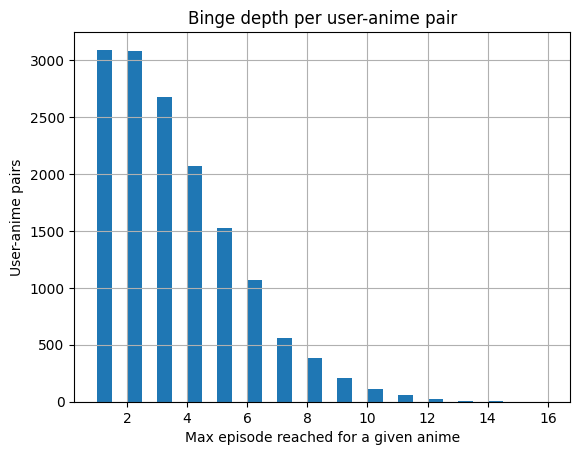

In [16]:
plt.figure()
per_user_anime_depth["max_episode_watched"].hist(bins=30)
plt.xlabel("Max episode reached for a given anime")
plt.ylabel("User-anime pairs")
plt.title("Binge depth per user-anime pair")
plt.show()

## Retention curves for popular anime

Next, we look at retention per anime, but only for a few popular titles.

Steps:

- Find the top N anime by total views
- For each, compute retention by episode
- Plot them together for comparison

In [17]:
N_TOP = 5

In [18]:
anime_counts = (
    logs_df.groupby(["anime_row_id", "anime_title"])["user_id"]
    .count()
    .rename("views")
    .reset_index()
    .sort_values("views", ascending=False)
)

In [19]:
top_anime = anime_counts.head(N_TOP)
top_anime

,anime_row_id,anime_title,views
2378,13202,Hunter x Hunter,35
3290,18145,Kusuriya no Hitorigoto,34
1340,7362,Dou Long Zhanshi,34
6045,33950,Tobot V Season 2,33
4386,24489,Ongaku Shoujo (TV),33


In [20]:
top_ids = top_anime["anime_row_id"].tolist()
top_logs = logs_df[logs_df["anime_row_id"].isin(top_ids)].copy()

In [21]:
per_anime_retention = (
    top_logs
    .groupby(["anime_title", "episode_number"])["label_next_episode"]
    .mean()
    .reset_index()
    .sort_values(["anime_title", "episode_number"])
)
per_anime_retention.head()

,anime_title,episode_number,label_next_episode
0,Dou Long Zhanshi,1,1.000000
1,Dou Long Zhanshi,2,1.000000
2,Dou Long Zhanshi,3,1.000000
3,Dou Long Zhanshi,4,0.666667
4,Dou Long Zhanshi,5,0.500000


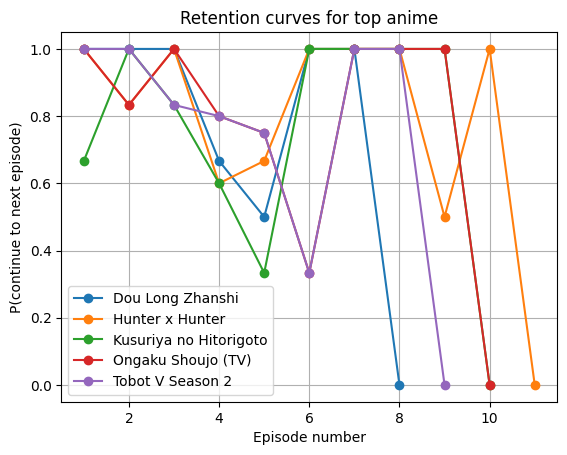

In [22]:
plt.figure()
for title, grp in per_anime_retention.groupby("anime_title"):
    plt.plot(
        grp["episode_number"],
        grp["label_next_episode"],
        marker="o",
        label=title,
    )
plt.xlabel("Episode number")
plt.ylabel("P(continue to next episode)")
plt.title("Retention curves for top anime")
plt.legend()
plt.grid(True)
plt.show()

## Time-based cohorts

We now build simple cohorts based on when a user first appears in the logs.

Definitions:

- `user_first_watch`: first `watch_start_time` for each user
- `cohort_date`: the date (no time) of `user_first_watch`
- `days_since_first`: integer days from first watch for that user

We can then see, for each cohort, how many users are still active as time passes.

In [23]:
# Ensure datetime type
logs_df["watch_start_time"] = pd.to_datetime(logs_df["watch_start_time"])

In [24]:
user_first_watch = (
    logs_df.groupby("user_id")["watch_start_time"]
    .min()
    .rename("user_first_watch")
    .reset_index()
)

In [25]:
logs_with_first = logs_df.merge(user_first_watch, on="user_id", how="left")
logs_with_first["cohort_date"] = logs_with_first["user_first_watch"].dt.normalize()
logs_with_first["days_since_first"] = (
    (logs_with_first["watch_start_time"] - logs_with_first["user_first_watch"])
    .dt.days
)
logs_with_first[["user_id", "watch_start_time", "user_first_watch", "cohort_date", "days_since_first"]].head()

,user_id,watch_start_time,user_first_watch,cohort_date,days_since_first
0,1,2024-01-11 00:00:00.000000,2024-01-01,2024-01-01,10
1,1,2024-01-12 05:33:18.614273,2024-01-01,2024-01-01,11
2,1,2024-01-12 07:19:33.763768,2024-01-01,2024-01-01,11
3,1,2024-01-01 00:00:00.000000,2024-01-01,2024-01-01,0
4,1,2024-01-02 19:40:27.893000,2024-01-01,2024-01-01,1


## Cohort survival table

For each `cohort_date` and `days_since_first`, we compute:

- `active_users`: number of users with at least one episode on that day_since_first
- `cohort_size`: total users in that cohort
- `survival_rate = active_users / cohort_size`

In [26]:
# Cohort size
cohort_sizes = (
    user_first_watch
    .assign(cohort_date=lambda df: df["user_first_watch"].dt.normalize())
    .groupby("cohort_date")["user_id"]
    .nunique()
    .rename("cohort_size")
    .reset_index()
)

In [27]:
# Active users by cohort and day_since_first
active_users = (
    logs_with_first
    .groupby(["cohort_date", "days_since_first"])["user_id"]
    .nunique()
    .rename("active_users")
    .reset_index()
)

In [28]:
cohort_survival = active_users.merge(cohort_sizes, on="cohort_date", how="left")
cohort_survival["survival_rate"] = (
    cohort_survival["active_users"] / cohort_survival["cohort_size"]
)
cohort_survival.head()

,cohort_date,days_since_first,active_users,cohort_size,survival_rate
0,2024-01-01,0,494,494,1.000000
1,2024-01-01,1,307,494,0.621457
2,2024-01-01,2,211,494,0.427126
3,2024-01-01,3,196,494,0.396761
4,2024-01-01,4,184,494,0.372470


In [29]:
# Pick up to 3 cohorts to visualize
unique_cohorts = sorted(cohort_survival["cohort_date"].unique())
plot_cohorts = unique_cohorts[:3]
plot_df = cohort_survival[cohort_survival["cohort_date"].isin(plot_cohorts)].copy()

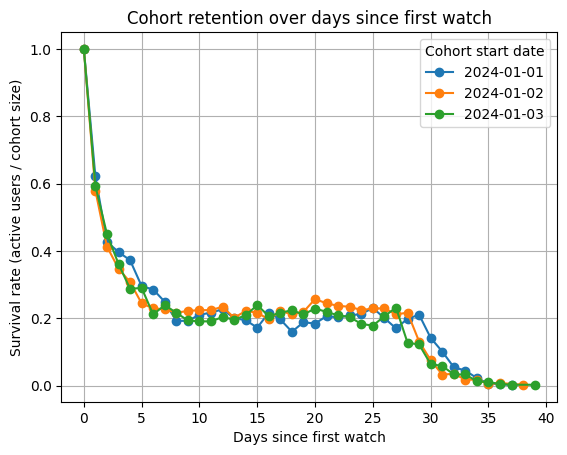

In [30]:
plt.figure()
for cohort in plot_cohorts:
    grp = plot_df[plot_df["cohort_date"] == cohort]
    label = cohort.strftime("%Y-%m-%d")
    plt.plot(
        grp["days_since_first"],
        grp["survival_rate"],
        marker="o",
        label=label,
    )
plt.xlabel("Days since first watch")
plt.ylabel("Survival rate (active users / cohort size)")
plt.title("Cohort retention over days since first watch")
plt.legend(title="Cohort start date")
plt.grid(True)
plt.show()

## Quick engagement segments

Because we simulated an `engagement_level` for each user, we can see how it ties to behavior.

We check:

- How total episodes watched varies by engagement quantile.

In [31]:
# Merge engagement back in (it is already in logs_df)
user_engagement = (
    logs_df.groupby("user_id")["engagement_level"]
    .max()
    .rename("engagement_level")
    .reset_index()
)

In [32]:
user_stats = user_total_episodes.merge(user_engagement, on="user_id", how="left")
user_stats["engagement_bucket"] = pd.qcut(
    user_stats["engagement_level"],
    q=4,
    labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"],
)

In [33]:
episodes_by_bucket = (
    user_stats
    .groupby("engagement_bucket")["episodes_watched"]
    .describe()[["mean", "50%", "max"]]
    .rename(columns={"50%": "median"})
    .reset_index()
)
print(episodes_by_bucket)

  engagement_bucket     mean  median   max
0          Q1 (low)   6.6736     6.0  24.0
1                Q2   8.5728     8.0  27.0
2                Q3  10.7504    10.0  32.0
3         Q4 (high)  14.5656    14.0  41.0


/var/folders/1f/6f0z03dx6vv938xkc8309_0w0000gn/T/ipykernel_32396/3062604157.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("engagement_bucket")["episodes_watched"]


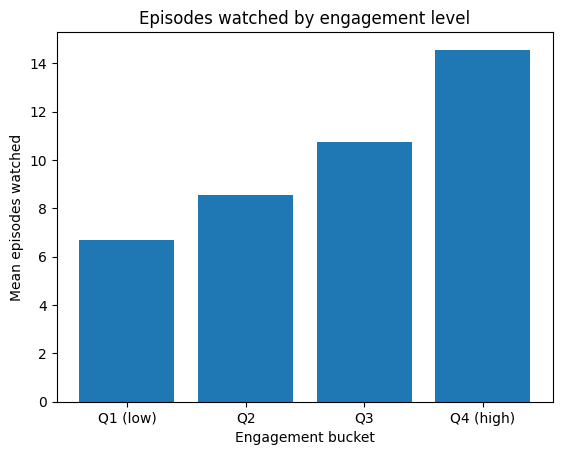

In [34]:
plt.figure()
plt.bar(
    episodes_by_bucket["engagement_bucket"].astype(str),
    episodes_by_bucket["mean"],
)
plt.xlabel("Engagement bucket")
plt.ylabel("Mean episodes watched")
plt.title("Episodes watched by engagement level")
plt.show()

## Summary

In this notebook we:

- Loaded the synthetic `viewing_logs.parquet` created by the pipeline
- Computed a global retention curve by episode number
- Looked at binge depth per user and per user-anime pair
- Compared retention curves for a few popular anime
- Built simple time-based cohorts and survival-style retention curves
- Related simulated `engagement_level` to total episodes watched

This gives us a good view of synthetic engagement behavior and sets up the next step:

- Turning these logs into ML features to predict `label_next_episode`.